In [81]:
#pip install cvxopt
#pip install cvxpy
#pip install PyPortfolioOpt

#conda install cvxopt
#conda install cvxpy
#conda install PyPortfolioOpt

"""
해당 파일은 python 3.7.15 버전에서 작성되었습니다.
일부 라이브러리의 버전 차이로 인해 실행이 되지 않을 수 있습니다.
설치가 되지 않는다면 pip install cvxopt, pip install cvxpy 먼저 실행 부탁드립니다.
"""

'\n해당 파일은 python 3.7.15 버전에서 작성되었습니다.\n일부 라이브러리의 버전 차이로 인해 실행이 되지 않을 수 있습니다.\n설치가 되지 않는다면 pip install cvxopt, pip install cvxpy 먼저 실행 부탁드립니다.\n'

In [82]:
import gc
gc.collect(generation=2)

31339

In [83]:
import pandas as pd
import numpy as np
from datetime import datetime
from pandas import to_datetime
import matplotlib.pyplot as plt
import time
import seaborn as sns
import pmdarima as pm
import math
from collections import OrderedDict
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

from news_function_all import * # 미리 정의해놓은 함수 import

In [84]:
# 포트폴리오 관련 library import

import cvxopt as opt # python version 3.6-3.10 가능
from cvxopt import solvers
from pypfopt.efficient_frontier import EfficientFrontier # 정확하게는 모르겠는데 3.7은 사용가능
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

In [85]:
df = pd.read_csv("C:/Users/User/github/Web_crawling/save_data/stock_data.csv", encoding='cp949')
score = pd.read_csv("C:/Users/User/github/Web_Crawling/save_data/total_rate.csv", encoding='cp949')

In [86]:
kospi = pd.read_csv("C:/Users/User/github/Web_Crawling/save_data/kospi_200.csv",encoding='cp949')

In [87]:
time = pd.date_range('2019-01-01','2023-01-01', freq='m')
kospi=kospi.sort_values('연월')
kospi['time'] = time
kospi.set_index('time', inplace=True)
kospi.drop('연월',axis=1, inplace=True)
kospi = kospi[['종가', '대비']]
kospi['kospi'] = kospi['대비']/kospi['종가']

In [88]:
market_price = 1000000
kospi_result = []
kkk_result = []

for i in range(0, len(kospi)):
    kkk = kospi.iloc[i,2] * market_price # 순수익
    kospi_price = market_price + kkk # 현재 내 재산 
    kospi_result.append(kospi_price)  # 내재산은 저장하고 // 다시 돌려줘
    market_price = kospi_price
    kkk_result.append(kkk) 

In [89]:
df.set_index('time', inplace=True)
#df['time'] = pd.DatetimeIndex(df['time'])

In [90]:
# train 데이터와 validation 데이터 나누기.
X_train = df[(df.index < '2019-01-01') & (df.index > "2014.01.01")]
X_valid = df[df.index >= '2019-01-01']

# 각 데이터의 사이즈 확인하기
print('X_train Shape', X_train.shape)
print('X_Valid Shape', X_valid.shape)

X_train Shape (48, 21)
X_Valid Shape (48, 21)


---
#### train 구간만 사용한 포트폴리오와 예측 구간까지 사용한 포트폴리오의 차이를 확인할 것입니다.
#### train 구간이 움직일때 포트폴리오를 다시 최적화를 진행합니다.
#### 즉 한달 주기로 포트폴리오를 다시 구성하는 것입니다.
#### 수수료는 없다고 가정합니다.
#### 처음 주식을 구매하고 주식을 전부 판매하고 다시 주식을 구매하는 것으로 돈을 계속 계산하게 됩니다.

#### 간단한 예시본 후에 최종적인 코드 보면 이해에 도움이 됩니다.

In [91]:
weights = np.ones(21) # 초기에 가중치를 1로 설정
weights = weights/21 # 이후 동일하게 1/22으로 나눠서 설정 (가중치 합은 항상 1)

returns=X_train.pct_change() # 단순 수익률 계산 => (다음날 값 +- 기준일 값)/기준일 값 으로 수익률 나옵니다.

cov_matrix_annual=returns.cov()*12 # 데이터 기준이 DAY가 아니라 MONTH이므로 12를 곱해 연간 수익률로 계산

port_variance= weights.T @ cov_matrix_annual @ weights # 포트폴리오 분산의 기대값 = WT * (공분산{= 시그마}) * W를 코드로 옆처럼 나타냄

port_volatility=np.sqrt(port_variance) # 포트폴리오 변동성의 기대값 = SQRT(WT * 공분산(=시그마) * W) // 그냥 표준편차 = 변동성

portfolioSimpleAnnualReturn=np.sum(returns.mean()*weights)*12 # 연간 수익률 계산 DAY가 아니라 MONTH기준이므로 12곱하면 됨

In [92]:
percent_var=str(round(port_variance,2)*100)+'%' # 연간 예상 분산
percent_vol=str(round(port_volatility,2)*100)+'%' # 연간 예상 변동성
percent_ret=str(round(portfolioSimpleAnnualReturn,2)*100)+'%' # 연간 예상 수익률

print('Expected Annual Return :'+ percent_ret )
print('Annual Volatility/risk :'+ percent_vol )
print('Annual Variance :'+ percent_var )

Expected Annual Return :2.0%
Annual Volatility/risk :13.0%
Annual Variance :2.0%


In [93]:
market_price = 1000000
market_solution = []
market_money = []
market_sol = pd.DataFrame(index=range(0,1), columns = df.columns)
market_profit = []
market_weights = np.ones(21)/21 # 초기에 가중치를 1로 설정
market_weights = dict(zip(list(df.columns),list(market_weights)))

for i in range(0,len(X_valid)):
    if i == 0:
        test_table = get_latest_prices(X_train)
    else:     
        test_table = get_latest_prices(X_valid.iloc[:i,:])
    
    da = DiscreteAllocation(market_weights, test_table, total_portfolio_value = market_price)

    data_2,solution_2 = da.lp_portfolio() 
    market_mat = pd.DataFrame.from_dict(data = data_2, orient='index', dtype='int').T
    market_sol = pd.merge(market_sol, market_mat, how = 'outer').fillna(0)
    market_solution = (market_sol.iloc[-1,:] @ X_valid.iloc[i,:].T) - market_price        
    market_price += market_solution 
    market_money.append(market_price)
    market_profit.append(market_solution)

In [94]:
1000000*market_price / X_train.iloc[-1,:] @ X_valid.iloc[-1,:] # 실제로 위의 포트폴리오를 구성했을 때의 수익

20753440494675.312

In [95]:
# Portfolio optimization

# Calculate the expexted returns and annualised sample covariance matrix of the asset returns
mu=expected_returns.mean_historical_return(X_train, frequency=12) # 앞과 동일하게 data가 month기준
S=risk_models.sample_cov(X_train, frequency= 12) # 앞과 동일하게 data가 month기준

# Optimize the max sharpe ratio
ef = EfficientFrontier(mu, S)
weights = ef.min_volatility()
#weights = ef.max_sharpe()
#weights = ef.max_quadratic_utility() 

cleaned_weights = ef.clean_weights() 
print(cleaned_weights) #Note the weights may have some rounding error, meaning they may not add up exactly to 1 but should be close
ef.portfolio_performance(verbose=True)

latest_prices = get_latest_prices(X_train)
weights = cleaned_weights 

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=1000000000000)
allocation, leftover = da.lp_portfolio()

print("Discrete allocation:", allocation) # 해당주를 얼마나 구입하는가
print("Funds remaining: ${:.2f}".format(leftover)) # 예상 수익

OrderedDict([('음식료품', 0.27415), ('섬유의복', 0.05202), ('종이목재', 0.0), ('화학', 0.0), ('의약품', 0.0), ('비금속광물', 0.0), ('철강금속', 0.0), ('기계', 0.0), ('전기전자', 0.22073), ('의료정밀', 0.00626), ('운수장비', 0.0), ('유통업', 0.0), ('전기가스업', 0.1168), ('건설업', 0.0), ('운수창고업', 0.00168), ('통신업', 0.13646), ('금융업', 0.0), ('은행', 0.10348), ('증권', 0.0), ('보험', 0.08841), ('서비스업', 0.0)])
Expected annual return: 0.3%
Annual volatility: 9.3%
Sharpe Ratio: -0.18
Discrete allocation: {'음식료품': 69229624, '섬유의복': 205199006, '전기전자': 15278584, '의료정밀': 2933679, '전기가스업': 111174567, '운수창고업': 1252526, '통신업': 342872937, '은행': 344233392, '보험': 5422832}
Funds remaining: $9982863.89


In [96]:
l = pd.DataFrame(index=range(0,1), columns = df.columns)
l_2 = pd.merge(l, pd.DataFrame.from_dict(data = allocation, orient='index', dtype='int').T, how = 'outer').fillna(0)
l_2.iloc[1,:]@X_valid.iloc[-1,:].T # 포트폴리오 실제 수익

981168152427.3

### Moving window

----
### 뉴스 정보와 결합

In [97]:
score_df = score[['음식료품_positive_rate','섬유의복_positive_rate','종이목재_positive_rate','화학_positive_rate','의약품_positive_rate','비금속광물_positive_rate','철강금속_positive_rate','기계_positive_rate','전기전자_positive_rate','의료정밀_positive_rate','운수장비_positive_rate','유통업_positive_rate','전기가스업_positive_rate','건설업_positive_rate','운수창고_positive_rate','통신업_positive_rate','금융업_positive_rate','은행_positive_rate','증권_positive_rate','보험_positive_rate','서비스업_positive_rate']]
score_df.columns = df.columns
score_df = score_df.fillna(int(0))
score_df['time'] = pd.date_range('2013-01-01','2022-12-31',freq='m')
score_df['time'] = score_df['time'].astype(str)
score_df.set_index('time', inplace=True) 
#score_df = score_df.set_index(pd.date_range('2013-01-01','2022-12-31',freq='m'))

In [98]:
plot_time = pd.date_range('2019-01-01','2022-12-31',freq='m')

---
## 최소분산 포트폴리오

In [99]:
a = 1000000
solution = []
money = []
profit = []
sol = pd.DataFrame(index=range(0,1), columns = df.columns)
finish_mat = pd.DataFrame(index = range(0,1), columns = df.columns)

for i in range(0,len(X_valid)):
    check = str(pd.date_range('2019-01-01','2022-12-31',freq='m')[i])[0:10]
    if i == 0:
        mu=expected_returns.mean_historical_return(X_train, frequency=12) # 앞과 동일하게 data가 month기준
        S = risk_models.sample_cov(X_train, frequency = 12)
    else:
        table = pd.concat([X_train.iloc[i:,:], X_valid.iloc[:i,:]]) 
        mu = expected_returns.mean_historical_return(table, frequency = 12)
        S = risk_models.sample_cov(table, frequency = 12)
    
    ef = EfficientFrontier(mu,S)

    weights = ef.min_volatility()    
    #weights = ef.max_quadratic_utility()      
    #weights = ef.max_sharpe()    
    
    cleaned_weights = ef.clean_weights()
    if i == 0:
        test_table = get_latest_prices(X_train)
    else:     
        test_table = get_latest_prices(X_valid.iloc[:i,:])
    j = np.where(score_df.index == check)

    finish_weight_2 = weight_cal(list(cleaned_weights.values()),score_df.iloc[j[0][0],:] )
    finish_weight_2.index = df.columns
    
    da = DiscreteAllocation(OrderedDict(finish_weight_2), test_table, total_portfolio_value = a)

    data,solution = da.lp_portfolio()
    #money.append(a)
    mat = pd.DataFrame.from_dict(data = data, orient='index', dtype='int').T
    sol = pd.merge(sol, mat, how = 'outer').fillna(0)
    solution = sol.iloc[-1,:] @ X_valid.iloc[i,:].T - a
    a += solution
    money.append(a)
    profit.append(solution)




In [100]:
b = 1000000
solution_2 = []
money_2 = []
sol_2 = pd.DataFrame(index=range(0,1), columns = df.columns)
profit_2 = []

for i in range(0,len(X_valid)):
    if i == 0:
        mu=expected_returns.mean_historical_return(X_train, frequency=12) # 앞과 동일하게 data가 month기준
        S = risk_models.sample_cov(X_train, frequency = 12)
    else:  
        table = pd.concat([X_train.iloc[i:,:], X_valid.iloc[:i,:]]) 
        mu = expected_returns.mean_historical_return(table, frequency = 12)
        S = risk_models.sample_cov(table, frequency = 12)

    # table = pd.concat([X_train.iloc[i:,:], X_valid.iloc[:i,:]])
    # mu = expected_returns.mean_historical_return(table, frequency = 12)
    # S = risk_models.sample_cov(table, frequency = 12)
    
    ef = EfficientFrontier(mu,S)
    weights_2 = ef.min_volatility()    
    #weights_2 = ef.max_quadratic_utility()
    #weights_2 = ef.max_sharpe()      
    cleaned_weights = ef.clean_weights() 
    if i == 0:
        test_table = get_latest_prices(X_train)
    else:     
        test_table = get_latest_prices(X_valid.iloc[:i,:])
    
    da = DiscreteAllocation(cleaned_weights, test_table, total_portfolio_value = b)

    data_2,solution_2 = da.lp_portfolio() 
    #money_2.append(b)
    mat_2 = pd.DataFrame.from_dict(data = data_2, orient='index', dtype='int').T
    sol_2 = pd.merge(sol_2, mat_2, how = 'outer').fillna(0)
    solution_2 = (sol_2.iloc[-1,:] @ X_valid.iloc[i,:].T) - b        
    #solution_2 = solution_2 - b   
    b += solution_2 
    money_2.append(b)
    profit_2.append(solution_2)

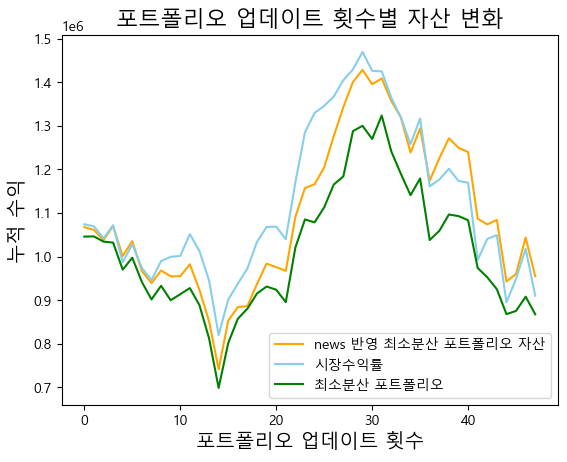

In [101]:
plt.plot(money, label = 'news 반영 최소분산 포트폴리오 자산', color = 'orange')
plt.plot(kospi_result, label = '시장수익률', color = 'skyblue')
plt.plot(money_2, label = '최소분산 포트폴리오', color = 'green')
plt.xlabel('포트폴리오 업데이트 횟수', size = 14)
plt.ylabel('누적 수익', size = 14)
plt.title('포트폴리오 업데이트 횟수별 자산 변화', size = 16)
plt.legend()
plt.show()

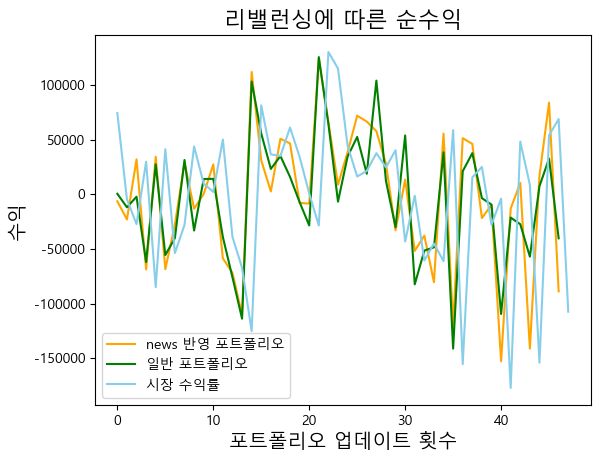

In [102]:
plt.title('리밸런싱에 따른 순수익', size = 16)
plt.plot(profit[1:], label = 'news 반영 포트폴리오', color = 'orange')
plt.plot(profit_2[1:], label = '일반 포트폴리오',color = 'green')
plt.plot(kkk_result, label = '시장 수익률', color = 'skyblue')
plt.xlabel('포트폴리오 업데이트 횟수', size = 14)
plt.ylabel('수익', size = 14)
plt.legend()
plt.show()

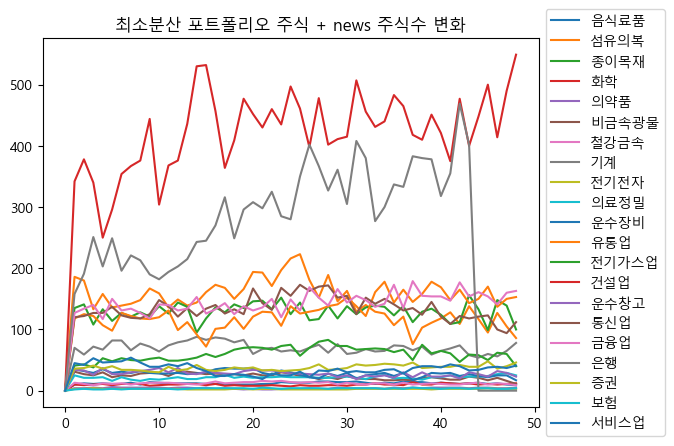

In [103]:
for i in range(0,len(df.columns)):
    plt.plot(sol.iloc[:,i], label = '{}'.format(category[i]))
plt.legend(loc = 'center left', bbox_to_anchor = (1,0.5))
plt.title('최소분산 포트폴리오 주식 + news 주식수 변화')
plt.show()

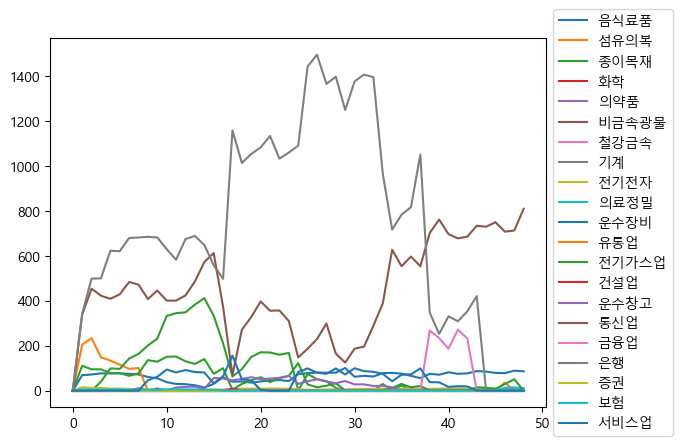

In [104]:
for i in range(0,len(df.columns)):
    plt.plot(sol_2.iloc[:,i], label = '{}'.format(category[i]))
plt.legend(loc = 'center left', bbox_to_anchor = (1,0.5))
plt.show()

---
## 최대분산 포트폴리오

In [105]:
a = 1000000
solution = []
money = []
profit = []
sol = pd.DataFrame(index=range(0,1), columns = df.columns)
finish_mat = pd.DataFrame(index = range(0,1), columns = df.columns)

for i in range(0,len(X_valid)):
    check = str(pd.date_range('2019-01-01','2022-12-31',freq='m')[i])[0:10]
    if i == 0:
        mu=expected_returns.mean_historical_return(X_train, frequency=12) # 앞과 동일하게 data가 month기준
        S = risk_models.sample_cov(X_train, frequency = 12)
    else:
        table = pd.concat([X_train.iloc[i:,:], X_valid.iloc[:i,:]]) 
        mu = expected_returns.mean_historical_return(table, frequency = 12)
        S = risk_models.sample_cov(table, frequency = 12)
    
    ef = EfficientFrontier(mu,S)

    #weights = ef.min_volatility()    
    weights = ef.max_quadratic_utility()      
    #weights = ef.max_sharpe()    
    
    cleaned_weights = ef.clean_weights()
    if i == 0:
        test_table = get_latest_prices(X_train)
    else:     
        test_table = get_latest_prices(X_valid.iloc[:i,:])
    j = np.where(score_df.index == check)

    finish_weight_2 = weight_cal(list(cleaned_weights.values()),score_df.iloc[j[0][0],:] )
    finish_weight_2.index = df.columns
    
    da = DiscreteAllocation(OrderedDict(finish_weight_2), test_table, total_portfolio_value = a)

    data,solution = da.lp_portfolio()
    #money.append(a)
    mat = pd.DataFrame.from_dict(data = data, orient='index', dtype='int').T
    sol = pd.merge(sol, mat, how = 'outer').fillna(0)
    solution = sol.iloc[-1,:] @ X_valid.iloc[i,:].T - a
    a += solution
    money.append(a)
    profit.append(solution)




In [106]:
b = 1000000
solution_2 = []
money_2 = []
sol_2 = pd.DataFrame(index=range(0,1), columns = df.columns)
profit_2 = []

for i in range(0,len(X_valid)):
    if i == 0:
        mu=expected_returns.mean_historical_return(X_train, frequency=12) # 앞과 동일하게 data가 month기준
        S = risk_models.sample_cov(X_train, frequency = 12)
    else:  
        table = pd.concat([X_train.iloc[i:,:], X_valid.iloc[:i,:]]) 
        mu = expected_returns.mean_historical_return(table, frequency = 12)
        S = risk_models.sample_cov(table, frequency = 12)

    # table = pd.concat([X_train.iloc[i:,:], X_valid.iloc[:i,:]])
    # mu = expected_returns.mean_historical_return(table, frequency = 12)
    # S = risk_models.sample_cov(table, frequency = 12)
    
    ef = EfficientFrontier(mu,S)
    #weights_2 = ef.min_volatility()    
    weights_2 = ef.max_quadratic_utility()
    #weights_2 = ef.max_sharpe()      
    cleaned_weights = ef.clean_weights() 
    if i == 0:
        test_table = get_latest_prices(X_train)
    else:     
        test_table = get_latest_prices(X_valid.iloc[:i,:])
    
    da = DiscreteAllocation(cleaned_weights, test_table, total_portfolio_value = b)

    data_2,solution_2 = da.lp_portfolio() 
    #money_2.append(b)
    mat_2 = pd.DataFrame.from_dict(data = data_2, orient='index', dtype='int').T
    sol_2 = pd.merge(sol_2, mat_2, how = 'outer').fillna(0)
    solution_2 = (sol_2.iloc[-1,:] @ X_valid.iloc[i,:].T) - b        
    #solution_2 = solution_2 - b   
    b += solution_2 
    money_2.append(b)
    profit_2.append(solution_2)

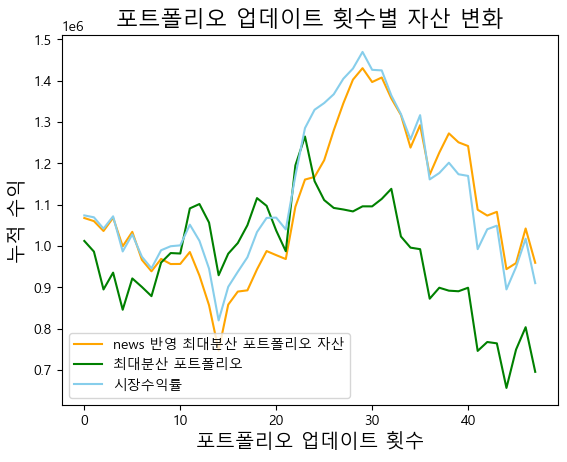

In [107]:
plt.plot(money, label = 'news 반영 최대분산 포트폴리오 자산', color = 'orange')
plt.plot(money_2, label = '최대분산 포트폴리오', color = 'green')
plt.plot(kospi_result, label = '시장수익률', color = 'skyblue')
plt.xlabel('포트폴리오 업데이트 횟수', size = 14)
plt.ylabel('누적 수익', size = 14)
plt.title('포트폴리오 업데이트 횟수별 자산 변화', size = 16)
plt.legend()
plt.show()

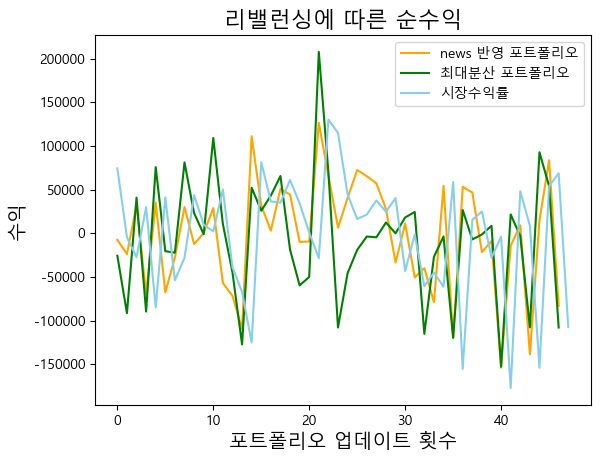

In [108]:
plt.title('리밸런싱에 따른 순수익', size = 16)
plt.plot(profit[1:], label = 'news 반영 포트폴리오', color = 'orange')
plt.plot(profit_2[1:], label = '최대분산 포트폴리오',color = 'green')
plt.plot(kkk_result, label = '시장수익률', color = 'skyblue')
plt.xlabel('포트폴리오 업데이트 횟수', size = 14)
plt.ylabel('수익', size = 14)
plt.legend()
plt.show()

---
## Max sharpe 포트폴리오 비교

In [109]:
a = 1000000
solution = []
money = []
profit = []
sol = pd.DataFrame(index=range(0,1), columns = df.columns)
finish_mat = pd.DataFrame(index = range(0,1), columns = df.columns)

for i in range(0,len(X_valid)):
    check = str(pd.date_range('2019-01-01','2022-12-31',freq='m')[i])[0:10]
    if i == 0:
        mu=expected_returns.mean_historical_return(X_train, frequency=12) # 앞과 동일하게 data가 month기준
        S = risk_models.sample_cov(X_train, frequency = 12)
    else:
        table = pd.concat([X_train.iloc[i:,:], X_valid.iloc[:i,:]]) 
        mu = expected_returns.mean_historical_return(table, frequency = 12)
        S = risk_models.sample_cov(table, frequency = 12)
    
    ef = EfficientFrontier(mu,S)

    #weights = ef.min_volatility()    
    #weights = ef.max_quadratic_utility()      
    weights = ef.max_sharpe()    
    
    cleaned_weights = ef.clean_weights()
    if i == 0:
        test_table = get_latest_prices(X_train)
    else:     
        test_table = get_latest_prices(X_valid.iloc[:i,:])
    j = np.where(score_df.index == check)

    finish_weight_2 = weight_cal(list(cleaned_weights.values()),score_df.iloc[j[0][0],:] )
    finish_weight_2.index = df.columns
    
    da = DiscreteAllocation(OrderedDict(finish_weight_2), test_table, total_portfolio_value = a)

    data,solution = da.lp_portfolio()
    #money.append(a)
    mat = pd.DataFrame.from_dict(data = data, orient='index', dtype='int').T
    sol = pd.merge(sol, mat, how = 'outer').fillna(0)
    solution = sol.iloc[-1,:] @ X_valid.iloc[i,:].T - a
    a += solution
    money.append(a)
    profit.append(solution)




In [110]:
b = 1000000
solution_2 = []
money_2 = []
sol_2 = pd.DataFrame(index=range(0,1), columns = df.columns)
profit_2 = []

for i in range(0,len(X_valid)):
    if i == 0:
        mu=expected_returns.mean_historical_return(X_train, frequency=12) # 앞과 동일하게 data가 month기준
        S = risk_models.sample_cov(X_train, frequency = 12)
    else:  
        table = pd.concat([X_train.iloc[i:,:], X_valid.iloc[:i,:]]) 
        mu = expected_returns.mean_historical_return(table, frequency = 12)
        S = risk_models.sample_cov(table, frequency = 12)

    # table = pd.concat([X_train.iloc[i:,:], X_valid.iloc[:i,:]])
    # mu = expected_returns.mean_historical_return(table, frequency = 12)
    # S = risk_models.sample_cov(table, frequency = 12)
    
    ef = EfficientFrontier(mu,S)
    #weights_2 = ef.min_volatility()    
    #weights_2 = ef.max_quadratic_utility()
    weights_2 = ef.max_sharpe(risk_free_rate=0.03)      
    cleaned_weights = ef.clean_weights() 
    if i == 0:
        test_table = get_latest_prices(X_train)
    else:     
        test_table = get_latest_prices(X_valid.iloc[:i,:])
    
    da = DiscreteAllocation(cleaned_weights, test_table, total_portfolio_value = b)

    data_2,solution_2 = da.lp_portfolio() 
    #money_2.append(b)
    mat_2 = pd.DataFrame.from_dict(data = data_2, orient='index', dtype='int').T
    sol_2 = pd.merge(sol_2, mat_2, how = 'outer').fillna(0)
    solution_2 = (sol_2.iloc[-1,:] @ X_valid.iloc[i,:].T) - b        
    #solution_2 = solution_2 - b   
    b += solution_2 
    money_2.append(b)
    profit_2.append(solution_2)

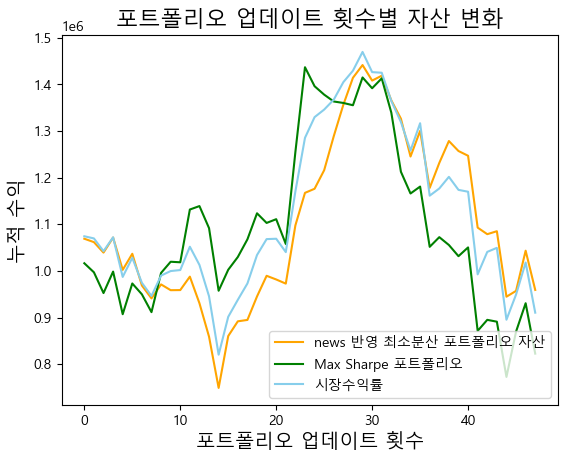

In [119]:
plt.plot(money, label = 'news 반영 최소분산 포트폴리오 자산', color = 'orange')
plt.plot(money_2, label = 'Max Sharpe 포트폴리오', color = 'green')
plt.plot(kospi_result, label = '시장수익률', color = 'skyblue')
plt.xlabel('포트폴리오 업데이트 횟수', size = 14)
plt.ylabel('누적 수익', size = 14)
plt.title('포트폴리오 업데이트 횟수별 자산 변화', size = 16)
plt.legend()
plt.show()

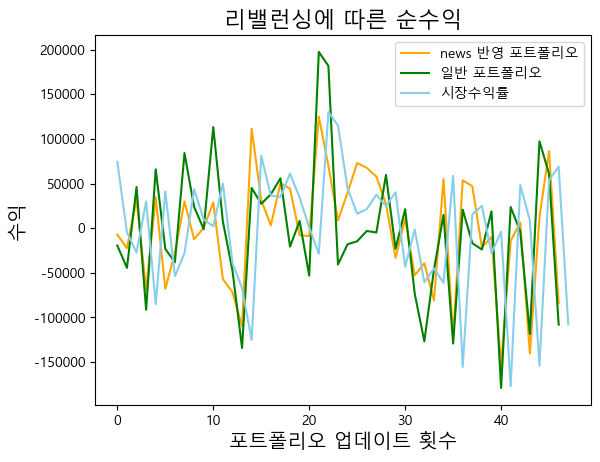

In [112]:
plt.title('리밸런싱에 따른 순수익', size = 16)
plt.plot(profit[1:], label = 'news 반영 포트폴리오', color = 'orange')
plt.plot(profit_2[1:], label = '일반 포트폴리오',color = 'green')
plt.plot(kkk_result, label = '시장수익률',color = 'skyblue')
plt.xlabel('포트폴리오 업데이트 횟수', size = 14)
plt.ylabel('수익', size = 14)
plt.legend()
plt.show()

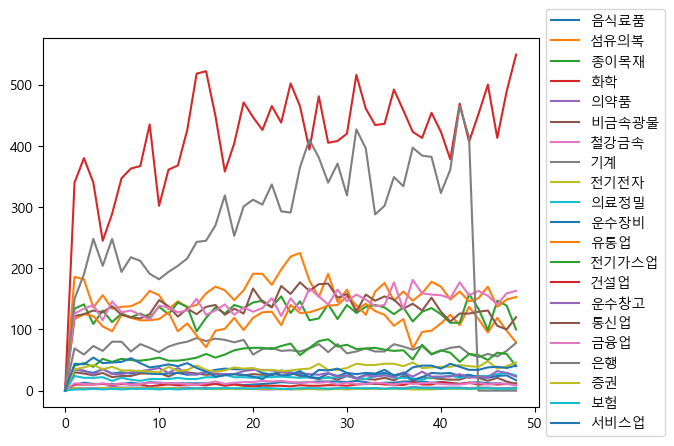

In [113]:
for i in range(0,len(df.columns)):
    plt.plot(sol.iloc[:,i], label = '{}'.format(category[i]))
plt.legend(loc = 'center left', bbox_to_anchor = (1,0.5))
plt.show()

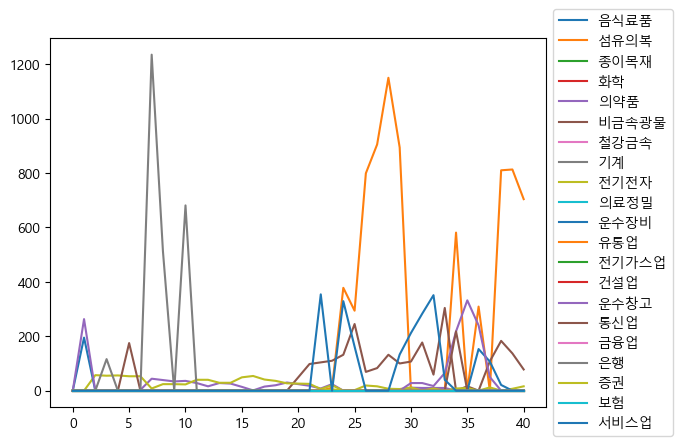

In [114]:
for i in range(0,len(df.columns)):
    plt.plot(sol_2.iloc[:,i], label = '{}'.format(category[i]))
plt.legend(loc = 'center left', bbox_to_anchor = (1,0.5))
plt.show()

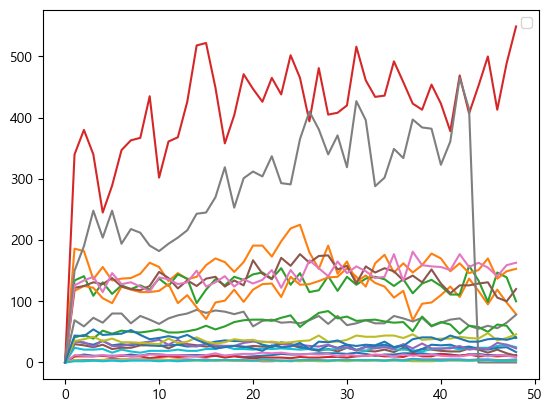

In [115]:
for i in range(len(sol.columns)):
    globals()['h{}'.format(i)] = plt.plot(sol.iloc[:,i])
    'h{}'.format(i)
plt.legend(handles=(h2, h3, h4, h5, h9, h10, h18),labels = {'섬유의복','종이목재','화학','의약품','전기전자','의료정밀','은행'}, loc='best' )
plt.show()
# 범례 안보임..

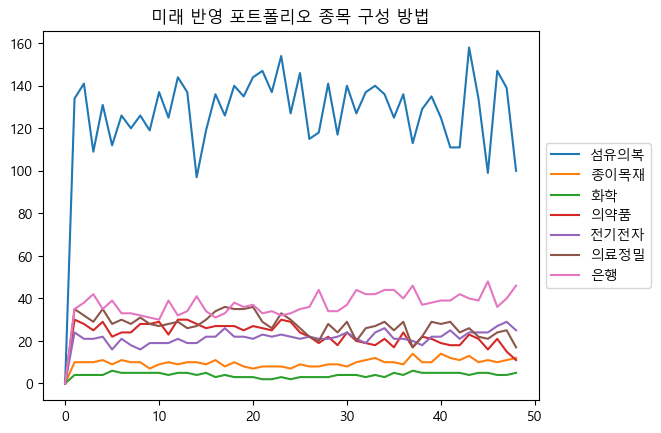

In [116]:
plt.plot(sol.iloc[:,2], label = '섬유의복')
plt.plot(sol.iloc[:,3], label = '종이목재')
plt.plot(sol.iloc[:,4], label = '화학')
plt.plot(sol.iloc[:,5], label = '의약품')
plt.plot(sol.iloc[:,9], label = '전기전자')
plt.plot(sol.iloc[:,10], label = '의료정밀')
plt.plot(sol.iloc[:,18], label = '은행')
plt.legend(loc = 'center left', bbox_to_anchor = (1,0.5))
plt.title('미래 반영 포트폴리오 종목 구성 방법')
plt.show()

In [117]:
sol_2.sum()!=0 # 주식을 한번도 구매하지 않은 경우를 확인하여 이런 경우는 plot을 찍지않음

음식료품     False
섬유의복      True
종이목재     False
화학       False
의약품       True
비금속광물     True
철강금속     False
기계        True
전기전자      True
의료정밀     False
운수장비      True
유통업      False
전기가스업    False
건설업      False
운수창고업     True
통신업       True
금융업       True
은행        True
증권        True
보험       False
서비스업      True
dtype: bool

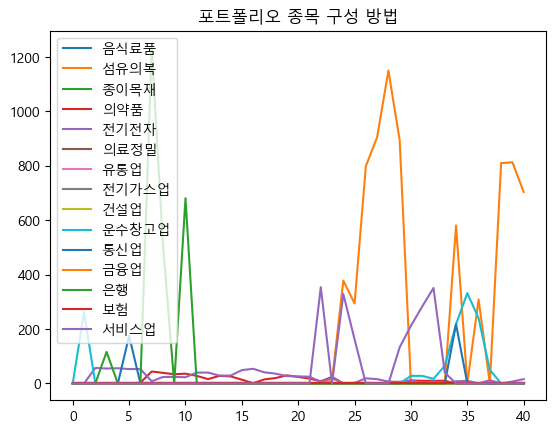

In [118]:
plt.plot(sol_2.iloc[:,0], label = '음식료품')
plt.plot(sol_2.iloc[:,1], label = '섬유의복')
plt.plot(sol_2.iloc[:,2], label = '종이목재')
plt.plot(sol_2.iloc[:,4], label = '의약품')
plt.plot(sol_2.iloc[:,8], label = '전기전자')
plt.plot(sol_2.iloc[:,9], label = '의료정밀')
plt.plot(sol_2.iloc[:,11], label = '유통업')
plt.plot(sol_2.iloc[:,12], label = '전기가스업')
plt.plot(sol_2.iloc[:,13], label = '건설업')
plt.plot(sol_2.iloc[:,14], label = '운수창고업')
plt.plot(sol_2.iloc[:,15], label = '통신업')
plt.plot(sol_2.iloc[:,16], label = '금융업')
plt.plot(sol_2.iloc[:,17], label = '은행')
plt.plot(sol_2.iloc[:,19], label = '보험')
plt.plot(sol_2.iloc[:,20], label = '서비스업')

plt.legend()
plt.title('포트폴리오 종목 구성 방법')
plt.show()

plt.plot(dict(cleaned_weights).values())